# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Imports

In [3]:
import datahandler
import plotter
import utils

import matplotlib.pyplot as plt
import matplotlib.pyplot
import matplotlib.dates
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.patches as mpatches
import scipy.stats
import folium
import seaborn as sns
import geopandas as gpd
import selenium
import PIL.Image
import io
import math
import folium.features
import folium.plugins


# Constants

In [4]:
DEPOT_INDEX_TO_COLOR = {
    0: "#a9a9a9",
    1: "#ffe119",
    2: "#aaffc3",
    3: "#4363d8",
    4: "#e6194B",
    5: "#42d4f4",
    6: "#808000",
    7: "#3cb44b",
    8: "#dcbeff",
    9: "#469990",
    10: "#000075",
    11: "#800000",
    12: "#bfef45",
    13: "#911eb4",
    14: "#f032e6",
    15: "#fabed4",
    16: "#ffd8b1",
    17: "#9A6324",
    18: "#f58231",
}


In [5]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(clean=False, processed=False, enhanced=True)


Cleaning dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Enhancing dataset:   0%|          | 0/2 [00:00<?, ?it/s]c:\Users\sindr\Documents\Emergency-Optimizers\Data-Processing\.venv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
Loading dataset: 100%|██████████| 2/2 [00:07<00:00,  3.62s/it]


# Methods


In [6]:
def add_info(dataframe: pd.DataFrame) -> pd.DataFrame:
    historic_steps = {
        "duration_incident_creation": ("time_call_received", "time_incident_created"),
        "duration_resource_appointment": ("time_incident_created", "time_resource_appointed"),
        "duration_resource_preparing_departure": ("time_resource_appointed", "time_ambulance_dispatch_to_scene"),
        "duration_dispatching_to_scene": ("time_ambulance_dispatch_to_scene", "time_ambulance_arrived_at_scene"),
        "duration_at_scene": ("time_ambulance_arrived_at_scene", "time_ambulance_dispatch_to_hospital", "time_ambulance_available"),
        "duration_dispatching_to_hospital": ("time_ambulance_dispatch_to_hospital", "time_ambulance_arrived_at_hospital"),
        "duration_at_hospital": ("time_ambulance_arrived_at_hospital", "time_ambulance_available")
    }

    for step, times in historic_steps.items():
        if len(times) == 3:
            dataframe.loc[dataframe[times[1]].isna(), step] = (dataframe[times[2]] - dataframe[times[0]]).dt.total_seconds()
            dataframe.loc[~dataframe[times[1]].isna(), step] = (dataframe[times[1]] - dataframe[times[0]]).dt.total_seconds()
        else:
            dataframe[step] = (dataframe[times[1]] - dataframe[times[0]]).dt.total_seconds()
    
    response_time_cols = [
        'duration_incident_creation',
        'duration_resource_appointment',
        'duration_resource_preparing_departure',
        'duration_dispatching_to_scene'
    ]
    dataframe['total_response_time'] = dataframe[response_time_cols].sum(axis=1)

    dataframe["complied"] = np.nan

    criteria = {
        ('A', True): 12 * 60,
        ('A', False): 25 * 60,
        ('H', True): 30 * 60,
        ('H', False): 40 * 60
    }

    for (triage, urban), group in dataframe.groupby(['triage_impression_during_call', 'urban_settlement_ssb']):
        limit = criteria.get((triage, urban))
        if limit is not None:
            dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit

    return dataframe


In [7]:
def plot_time_distribution(dataframe: pd.DataFrame):
    dataframe['hour'] = dataframe['time_call_received'].dt.hour
    dataframe['minute'] = dataframe['time_call_received'].dt.minute
    dataframe['second'] = dataframe['time_call_received'].dt.second

    fig = plt.figure(figsize=(10, 8))
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
    ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
    ax_legend = plt.subplot2grid((2, 2), (0, 1), colspan=2, rowspan=2)

    triage_to_name = {
        "A": "Acute",
        "H": "Urgent",
        "V1": "Non-Urgent"
    }

    time_components = ['hour', 'minute', 'second']
    axs = [ax1, ax2, ax3]
    titles = ["Hour", "Minute", "Second"]

    lines = []
    labels = []

    for ax, component in zip(axs, time_components):
        for category in ["A", "H", "V1"]:
            subset = dataframe[dataframe['triage_impression_during_call'] == category]
            count_series = subset[component].value_counts(normalize=True).sort_index() * 100

            line, = ax.plot(count_series.index, count_series.values)
            if len(labels) < 3:
                lines.append(line)
                labels.append(f"{triage_to_name[category]}")

        # add total
        count_series = dataframe[component].value_counts(normalize=True).sort_index() * 100
        line, = ax.plot(count_series.index, count_series.values, "--", color="black", alpha=0.8)
        if len(labels) < 4:
            lines.append(line)
            labels.append(f"All")

        ax.set_title(f"Probability Distribution of {titles[time_components.index(component)]}", fontdict=constants.FONT_PROPERTIES_SUB_HEADER)
        ax.set_xlabel(titles[time_components.index(component)])
        if component != "second":
            ax.set_ylabel("Probability (%)")
        
        if component == 'hour':
            ax.set_xticks(range(0, 24))
            ax.set_xlim((0, 23))
            ax.set_ylim(top=10)
        else:
            ax.set_xticks(range(0, 60, 5))
            ax.set_xlim((0, 59))
            ax.set_ylim(top=2.5)
        
        ax.set_ylim(bottom=0)

    ax_legend.axis('off')
    ax_legend.legend(lines, labels, loc='upper right', title="Triage Impression")

    title = "Probability Distribution of Emergency Call by Triage Impression"

    fig.suptitle(title, **constants.FONT_PROPERTIES_HEADER)

    plt.tight_layout()

    plt.savefig(os.path.join(constants.PROJECT_DIRECTORY_PATH, "source", "analysis", "plots", title.replace("\n", " ") + ".png"), dpi=300, bbox_inches='tight')
    
    plt.show()


In [8]:
def plot_cancellation_distribution(dataframe: pd.DataFrame):
    # determine whether the ambulance dispatch was cancelled based on the field being NaN
    dataframe["cancelled"] = dataframe["time_ambulance_dispatch_to_hospital"].isna()
    dataframe['hour'] = dataframe['time_call_received'].dt.hour

    # filter the data to include only cancellations
    cancelled_data = dataframe[dataframe["cancelled"]]

    triage_to_name = {
        "A": "Acute",
        "H": "Urgent",
        "V1": "Non-Urgent"
    }

    cancellation_probs = cancelled_data.groupby(['hour', 'triage_impression_during_call']).size()
    total_counts = dataframe.groupby(['hour', 'triage_impression_during_call']).size()
    cancellation_probs = (cancellation_probs / total_counts).unstack().fillna(0) * 100

    fig, ax = plt.subplots(figsize=(9, 6))

    lines = cancellation_probs.plot(ax=ax, marker='o')

    # highlight day shift hours with a different background color
    ax.axvspan(7, 19, color='lightgray', alpha=0.5, label='Day Shift')

    title = "Cancellation Probability Distribution by Triage Impression"

    ax.set_title(title, fontdict=constants.FONT_PROPERTIES_SUB_HEADER)
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Probability (%)")
    ax.set_xticks(range(24))
    ax.set_xlim((0, 23))
    ax.set_ylim(bottom=0)

    ax.grid(True)

    legend_labels = [triage_to_name.get(label, label) for label in cancellation_probs.columns]
    ax.legend(legend_labels + ['Day Shift'], title="Triage Impression", loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()

    plt.savefig(os.path.join(constants.PROJECT_DIRECTORY_PATH, "source", "analysis", "plots", title.replace("\n", " ") + ".png"), dpi=300, bbox_inches='tight')

    plt.show()


In [9]:
def plot_incident_spatial_heatmap(dataframe: pd.DataFrame):
    triage_to_name = {
        "A": "Acute",
        "H": "Urgent",
        "V1": "Non-Urgent"
    }

    # calculate center and bounds for the map
    sw = dataframe[['latitude', 'longitude']].min().values.tolist()
    ne = dataframe[['latitude', 'longitude']].max().values.tolist()
    center = dataframe[['latitude', 'longitude']].mean().values.tolist()

    # define shifts
    dataframe['shift'] = 'Night Shift'
    dataframe.loc[dataframe['time_call_received'].dt.hour.between(7, 18), 'shift'] = 'Day Shift'

    triage_categories = ["A", "H", "V1"]
    shifts = ['Day Shift', 'Night Shift']
    images = []

    for shift in shifts:
        for triage in triage_categories:
            filtered_df = dataframe[(dataframe['triage_impression_during_call'] == triage) & (dataframe['shift'] == shift)]

            grid_id_count = filtered_df["grid_id"].value_counts()
            grid_id_count_log = np.log1p(grid_id_count)
            norm = plt.Normalize(grid_id_count_log.min(), grid_id_count_log.max())
            colormap = matplotlib.colormaps["viridis"]

            m = folium.Map(location=center, zoom_start=12)
            CartoDB_PositronNoLabels = folium.TileLayer(
                tiles='https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
                attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
                subdomains='abcd',
                max_zoom=20,
                name='CartoDB Positron No Labels'
            )
            CartoDB_PositronNoLabels.add_to(m)

            for grid_id, count in grid_id_count_log.items():
                x, y = utils.id_to_utm(grid_id)
                polygon_coords = utils.get_cell_corners(x, y)
                color = colormap(norm(count))
                folium.Polygon(
                    locations=polygon_coords,
                    color=None,
                    fill=True,
                    fill_color=matplotlib.colors.rgb2hex(color),
                    fill_opacity=0.7
                ).add_to(m)

            m.fit_bounds([sw, ne])

            # render map to PNG image
            img_data = m._to_png()
            img = PIL.Image.open(io.BytesIO(img_data))
            sides_crop = 540
            top_crop = 180
            img = img.crop((sides_crop, top_crop, img.width - sides_crop, img.height - top_crop))
            images.append((img, f"{triage_to_name[triage]}", f"{shift}"))

    rows = len(shifts)
    cols = len(triage_categories)
    fig, axs = plt.subplots(rows, cols, figsize=(12, 10))

    for idx, (img, triage, shift) in enumerate(images):
        ax = axs[idx // cols, idx % cols]
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if shift == 'Day Shift':
            ax.set_title(triage, fontdict=constants.FONT_PROPERTIES_SUB_HEADER)
        if triage == "Acute":
            ax.set_ylabel(shift)

    title = "Spatial Distribution of Incident Frequencies by Triage Category and Shift"

    fig.suptitle(title, **constants.FONT_PROPERTIES_HEADER)

    plt.tight_layout()

    plt.savefig(os.path.join(constants.PROJECT_DIRECTORY_PATH, "source", "analysis", "plots", title.replace("\n", " ") + ".png"), dpi=300, bbox_inches='tight')

    plt.show()


In [10]:
def plot_cluster(dataframe: pd.DataFrame):
    dataframe_depots = data_preprocessor.load_enhanced_depots_dataframe()

    grid_count = dataframe["grid_id"].value_counts()

    grid_id_to_depot = {grid_id: -1 for grid_id, _ in grid_count.items()}
    depot_to_urban = {depot_index: (0, 0, 0, 0) for depot_index in list(range(19))}

    split_depots = [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 18]

    for grid_id, _ in grid_id_to_depot.items():
        min_distance = float('inf')
        closest_depot_index = -1

        cell_utm = utils.id_to_utm(grid_id)
        cell_utm = (cell_utm[0] + 500, cell_utm[1] + 500)

        for depot_index, depot in dataframe_depots.iterrows():
            if (depot["type"] != "Depot" and depot["type"] != "Beredskapspunkt"):
                continue

            depot_utm = (depot["x"] + 500, depot["y"] + 500)

            distance = math.dist(cell_utm, depot_utm)

            if (closest_depot_index == -1 or distance < min_distance):
                closest_depot_index = depot_index
                min_distance = distance
        
        grid_id_to_depot[grid_id] = closest_depot_index

        urban = 0
        rural = 0
        if (dataframe["urban_settlement_ssb"].loc[(dataframe['grid_id'] == grid_id).idxmax()]):
            urban = 1
        else:
            rural = 1
        
        complied = 0
        if (dataframe["complied"].loc[(dataframe['grid_id'] == grid_id).idxmax()]):
            complied = 1

        depot_to_urban[closest_depot_index] = (
            depot_to_urban[closest_depot_index][0] + urban,
            depot_to_urban[closest_depot_index][1] + rural,
            depot_to_urban[closest_depot_index][2] + complied,
            depot_to_urban[closest_depot_index][3] + 1
        )
    
    # calculate center and bounds for the map
    sw = dataframe[['latitude', 'longitude']].min().values.tolist()
    ne = dataframe[['latitude', 'longitude']].max().values.tolist()
    center = dataframe[['latitude', 'longitude']].mean().values.tolist()

    images = []

    m = folium.Map(location=center, zoom_start=12)
    CartoDB_PositronNoLabels = folium.TileLayer(
        tiles='https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
        attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
        subdomains='abcd',
        max_zoom=20,
        name='CartoDB Positron No Labels'
    )
    CartoDB_PositronNoLabels.add_to(m)

    for grid_id, depot_index in grid_id_to_depot.items():
        x, y = utils.id_to_utm(grid_id)
        polygon_coords = utils.get_cell_corners(x, y)
        folium.Polygon(
            locations=polygon_coords,
            color=None,
            fill=True,
            fill_color=DEPOT_INDEX_TO_COLOR[depot_index],
            fill_opacity=0.6
        ).add_to(m)

    for depot_index in list(range(19)):
        if depot_index in split_depots:
            continue

        text = folium.Marker(
            location=(
                dataframe_depots["latitude"].iloc[depot_index],
                dataframe_depots["longitude"].iloc[depot_index]
            ),
            icon=folium.features.DivIcon(
                icon_size=(30, 20),
                icon_anchor=(15, 0),
                html='''
                    <div style="width: 30px; height: 20px; position: relative; font-size: 9pt; color: black; text-shadow: 
                        -1px -1px 0 #fff, 1px -1px 0 #fff, -1px 1px 0 #fff, 1px 1px 0 #fff;
                        display: flex; flex-direction: column; align-items: center; justify-content: flex-start;">
                        <div style="width: 4px; height: 4px; background-color: black; border-radius: 50%; 
                            margin-top: 2px;"></div>  <!-- Black dot at the top -->
                        <div style="position: absolute; bottom: -2px; text-align: center; width: 100%;">{label}</div> <!-- Text positioned below -->
                    </div>
                '''.format(label=dataframe_depots["name"].iloc[depot_index])
            )
        )
        text.add_to(m)

    m.fit_bounds([sw, ne])

    img_data = m._to_png()
    img = PIL.Image.open(io.BytesIO(img_data))
    sides_crop = 540
    top_crop = 180
    img = img.crop((sides_crop, top_crop, img.width - sides_crop, img.height - top_crop))
    images.append((img, "Oslo and Akershus"))



    # map of oslo
    center = [59.911889, 10.745541]
    m = folium.Map(location=center, zoom_start=10)
    CartoDB_PositronNoLabels = folium.TileLayer(
        tiles='https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
        attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
        subdomains='abcd',
        max_zoom=20,
        name='CartoDB Positron No Labels'
    )
    CartoDB_PositronNoLabels.add_to(m)

    # Add polygons
    for grid_id, depot_index in grid_id_to_depot.items():
        x, y = utils.id_to_utm(grid_id)
        polygon_coords = utils.get_cell_corners(x, y)
        folium.Polygon(
            locations=polygon_coords,
            color=None,
            fill=True,
            fill_color=DEPOT_INDEX_TO_COLOR[depot_index],
            fill_opacity=0.6
        ).add_to(m)

    for depot_index in list(range(19)):
        if depot_index in split_depots:
            text = folium.Marker(
                location=(
                    dataframe_depots["latitude"].iloc[depot_index],
                    dataframe_depots["longitude"].iloc[depot_index]
                ),
                icon=folium.features.DivIcon(
                    icon_size=(60, 40),
                    icon_anchor=(30, 0),
                    html='''
                        <div style="width: 60px; height: 40px; position: relative; font-size: 18pt; color: black; text-shadow: 
                            -1px -1px 0 #fff, 1px -1px 0 #fff, -1px 1px 0 #fff, 1px 1px 0 #fff;
                            display: flex; flex-direction: column; align-items: center; justify-content: flex-start;">
                            <div style="width: 8px; height: 8px; background-color: black; border-radius: 50%; 
                                margin-top: 4px;"></div>  <!-- Larger black dot at the top -->
                            <div style="position: absolute; bottom: -4px; text-align: center; width: 100%;">{label}</div> <!-- Text positioned below -->
                        </div>
                    '''.format(label=dataframe_depots["name"].iloc[depot_index])
                )
            )
            text.add_to(m)

    img_data = m._to_png()
    img = PIL.Image.open(io.BytesIO(img_data))
    sides_crop = 380
    top_crop = 10
    img = img.crop((sides_crop, top_crop, img.width - sides_crop, img.height - top_crop))
    images.append((img, "Focused on Oslo Region"))

    fig, axs = plt.subplots(1, 2, figsize=(12, 10))

    for idx, (img, label) in enumerate(images):
        ax = axs[idx]
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        ax.set_title(label, fontdict=constants.FONT_PROPERTIES_SUB_HEADER)

    title = "Grid Cells Clustered Around Depots"

    fig.suptitle(title, **constants.FONT_PROPERTIES_HEADER)

    plt.tight_layout()

    plt.savefig(os.path.join(constants.PROJECT_DIRECTORY_PATH, "source", "analysis", "plots", title.replace("\n", " ") + ".png"), dpi=300, bbox_inches='tight')

    plt.show()

    total_urban_count = 0
    total_rural_count = 0
    for depot_index, (urban_count, rural_count, complied, total) in depot_to_urban.items():
        total_urban_count += urban_count
        total_rural_count += rural_count

    for depot_index, (urban_count, rural_count, complied, total) in depot_to_urban.items():
        #print(f"{dataframe_depots['name'].loc[depot_index]}: urban count {(urban_count / total_urban_count) * 100:.2f}%, non-urban count: {(rural_count / total_rural_count) * 100:.2f}%, compliance rate: {(complied / total) * 100:.2f}%")
        print(f"{dataframe_depots['name'].loc[depot_index]}: urban count {(urban_count / total) * 100:.2f}%, total: {total}")


In [11]:
# this commented code is for another version of the clustering plot, opens chrome

"""
import pandas as pd
import folium
import os
import math
import utils
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
import time
import json

def plot_cluster_website(dataframe: pd.DataFrame):
    dataframe_depots = data_preprocessor.load_enhanced_depots_dataframe()

    grid_count = dataframe["grid_id"].value_counts()

    grid_id_to_depot = {grid_id: -1 for grid_id, _ in grid_count.items()}
    depot_to_urban = {depot_index: (0, 0, 0, 0) for depot_index in list(range(19))}

    split_depots = [1,2,3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 18]

    for grid_id, _ in grid_id_to_depot.items():
        min_distance = float('inf')
        closest_depot_index = -1

        cell_utm = utils.id_to_utm(grid_id)
        cell_utm = (cell_utm[0] + 500, cell_utm[1] + 500)

        for depot_index, depot in dataframe_depots.iterrows():
            if (depot["type"] != "Depot" and depot["type"] != "Beredskapspunkt"):
                continue

            depot_utm = (depot["x"] + 500, depot["y"] + 500)

            distance = math.dist(cell_utm, depot_utm)

            if (closest_depot_index == -1 or distance < min_distance):
                closest_depot_index = depot_index
                min_distance = distance
        
        grid_id_to_depot[grid_id] = closest_depot_index

        urban = 0
        rural = 0
        if (dataframe["urban_settlement_ssb"].loc[(dataframe['grid_id'] == grid_id).idxmax()]):
            urban = 1
        else:
            rural = 1
        
        complied = 0
        if (dataframe["complied"].loc[(dataframe['grid_id'] == grid_id).idxmax()]):
            complied = 1

        depot_to_urban[closest_depot_index] = (
            depot_to_urban[closest_depot_index][0] + urban,
            depot_to_urban[closest_depot_index][1] + rural,
            depot_to_urban[closest_depot_index][2] + complied,
            depot_to_urban[closest_depot_index][3] + 1
        )
    
    # Calculate center and bounds for the map
    sw = dataframe[['latitude', 'longitude']].min().values.tolist()
    ne = dataframe[['latitude', 'longitude']].max().values.tolist()
    center = dataframe[['latitude', 'longitude']].mean().values.tolist()

    # Create map
    m = folium.Map(location=center, zoom_start=12)
    CartoDB_PositronNoLabels = folium.TileLayer(
        tiles='https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
        attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
        subdomains='abcd',
        max_zoom=20,
        name='CartoDB Positron No Labels'
    )
    CartoDB_PositronNoLabels.add_to(m)

    # Add polygons
    for grid_id, depot_index in grid_id_to_depot.items():
        x, y = utils.id_to_utm(grid_id)
        polygon_coords = utils.get_cell_corners(x, y)
        folium.Polygon(
            locations=polygon_coords,
            color=None,
            fill=True,
            fill_color=DEPOT_INDEX_TO_COLOR[depot_index],
            fill_opacity=0.6
        ).add_to(m)

    for depot_index in list(range(19)):
        if depot_index in split_depots:
            continue

        text = folium.Marker(
            location=(
                dataframe_depots["latitude"].iloc[depot_index],
                dataframe_depots["longitude"].iloc[depot_index]
            ),
            icon=folium.features.DivIcon(
                icon_size=(30, 20),
                icon_anchor=(15, 0),
                html='''
                    <div style="width: 30px; height: 20px; position: relative; font-size: 9pt; color: black; text-shadow: 
                        -1px -1px 0 #fff, 1px -1px 0 #fff, -1px 1px 0 #fff, 1px 1px 0 #fff;
                        display: flex; flex-direction: column; align-items: center; justify-content: flex-start;">
                        <div style="width: 4px; height: 4px; background-color: black; border-radius: 50%; 
                            margin-top: 2px;"></div>  <!-- Black dot at the top -->
                    </div>
                '''.format(label=dataframe_depots["name"].iloc[depot_index])
            )
        )
        text.add_to(m)

    #akershus_gdf = gpd.read_file(os.path.join(constants.PROJECT_DIRECTORY_PATH, "data", "ssb_2019_akershus_polygon_epsg4326.geojson"))
    #oslo_gdf = gpd.read_file(os.path.join(constants.PROJECT_DIRECTORY_PATH, "data", "ssb_2019_oslo_polygon_epsg4326.geojson"))

    #akershus_gdf['dissolve_field'] = 'Region'
    #oslo_gdf['dissolve_field'] = 'Region'
    #combined_gdf = pd.concat([akershus_gdf, oslo_gdf], ignore_index=True)
    #dissolved_gdf = combined_gdf.dissolve(by='dissolve_field')

    #oslo_akershus_geojson = json.loads(dissolved_gdf.to_json())

    #folium.GeoJson(
    #    oslo_akershus_geojson,
    #    name='Oslo og Akershus',
    #    style_function=lambda x: {'fillColor': 'transparent', 'color': 'black'}
    #).add_to(m)
    #m.fit_bounds([sw, ne])

    # Save the map as an HTML file
    html_path = os.path.join(constants.PROJECT_DIRECTORY_PATH, "source", "analysis", "plots", "clustered_depots_map.html")
    m.save(html_path)

    # Open the HTML file using Selenium
    options = webdriver.ChromeOptions()
    options.add_argument("--start-maximized")

    driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)
    driver.get(f"file://{html_path}")
    # Close the browser
    driver.quit()

plot_cluster_website(dataframe)

# Selenium part to open the browser and take a screenshot
driver = webdriver.Chrome()  # This will open the browser

html_path = os.path.join(constants.PROJECT_DIRECTORY_PATH, "source", "analysis", "plots", "clustered_depots_map.html")
# Open the saved HTML file
driver.get('file:///' + os.path.abspath(html_path))

time.sleep(10)
driver.save_screenshot('clustered_depots_zoom.png')
driver.quit()

"""

'\nimport pandas as pd\nimport folium\nimport os\nimport math\nimport utils\nfrom selenium import webdriver\nfrom selenium.webdriver.chrome.service import Service as ChromeService\nfrom webdriver_manager.chrome import ChromeDriverManager\nimport time\nimport json\n\ndef plot_cluster_website(dataframe: pd.DataFrame):\n    dataframe_depots = data_preprocessor.load_enhanced_depots_dataframe()\n\n    grid_count = dataframe["grid_id"].value_counts()\n\n    grid_id_to_depot = {grid_id: -1 for grid_id, _ in grid_count.items()}\n    depot_to_urban = {depot_index: (0, 0, 0, 0) for depot_index in list(range(19))}\n\n    split_depots = [1,2,3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 18]\n\n    for grid_id, _ in grid_id_to_depot.items():\n        min_distance = float(\'inf\')\n        closest_depot_index = -1\n\n        cell_utm = utils.id_to_utm(grid_id)\n        cell_utm = (cell_utm[0] + 500, cell_utm[1] + 500)\n\n        for depot_index, depot in dataframe_depots.iterrows():\n            if (dep

# Main

In [12]:
dataframe = data_loader.enhanced_incidents_df.copy(deep=True)
dataframe = add_info(dataframe)


C:\Users\sindr\AppData\Local\Temp\ipykernel_14736\1926890535.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit


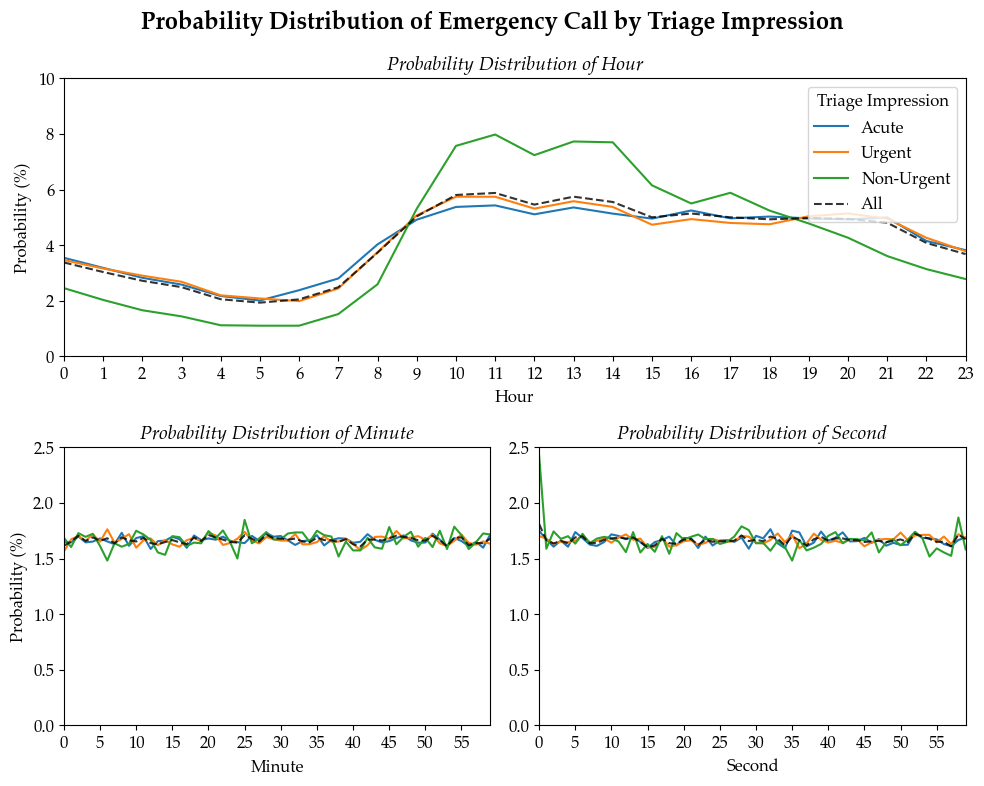

In [13]:
plot_time_distribution(dataframe)


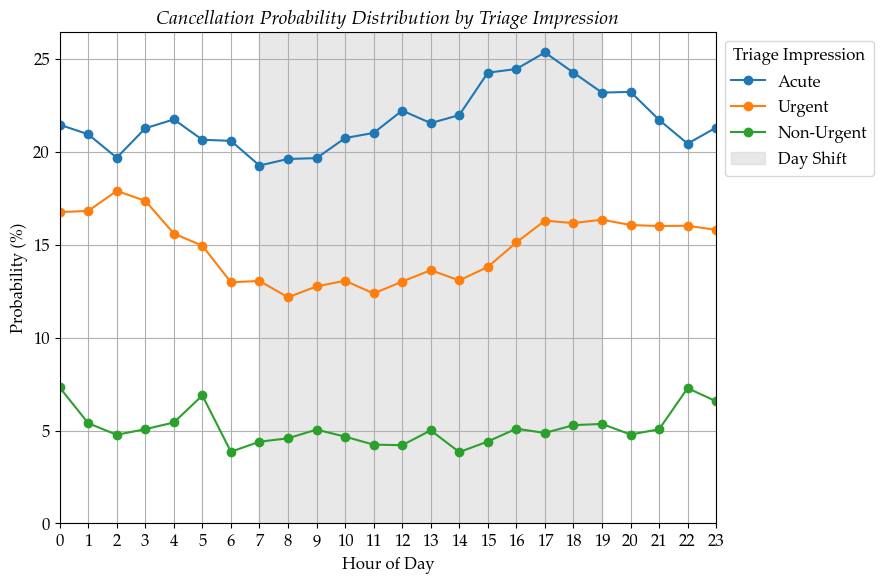

In [14]:
plot_cancellation_distribution(dataframe)


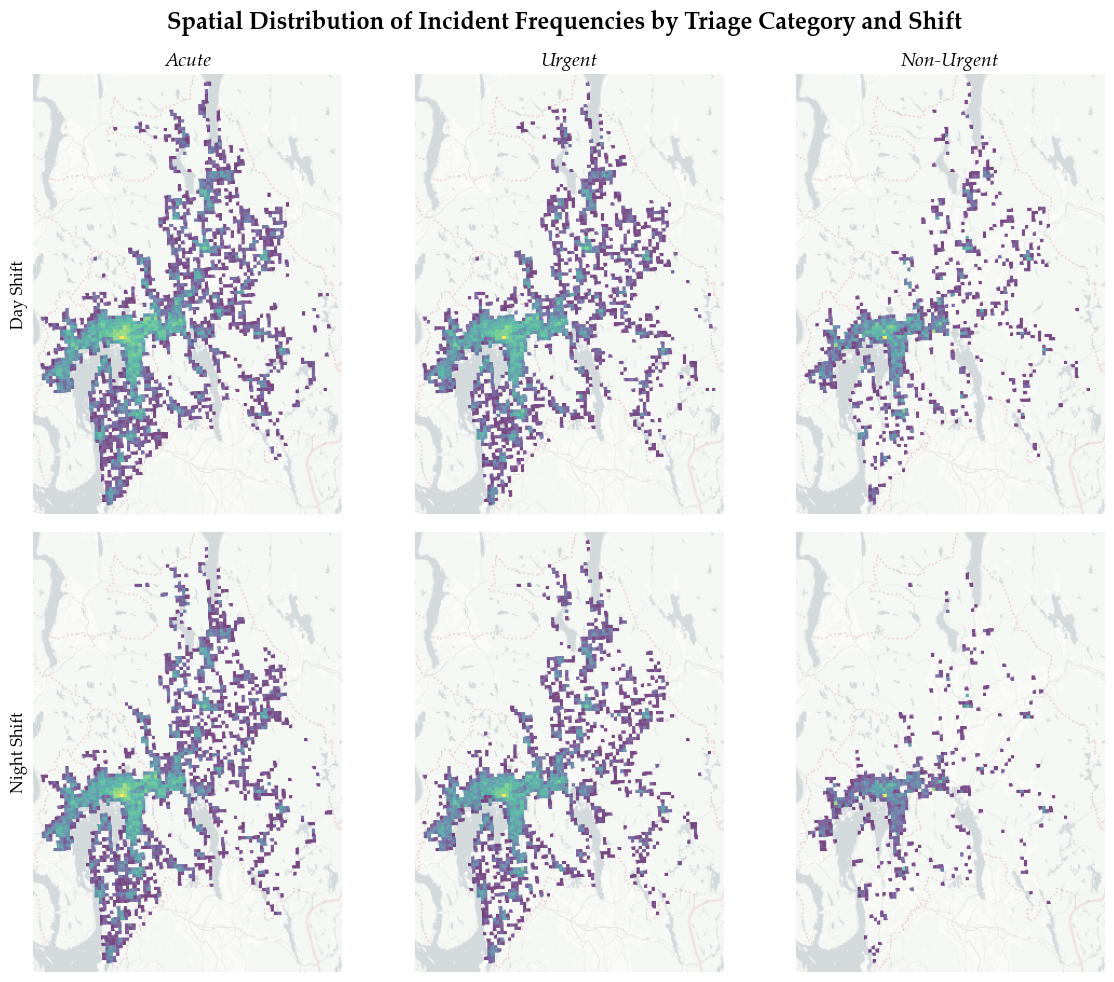

In [15]:
plot_incident_spatial_heatmap(dataframe)


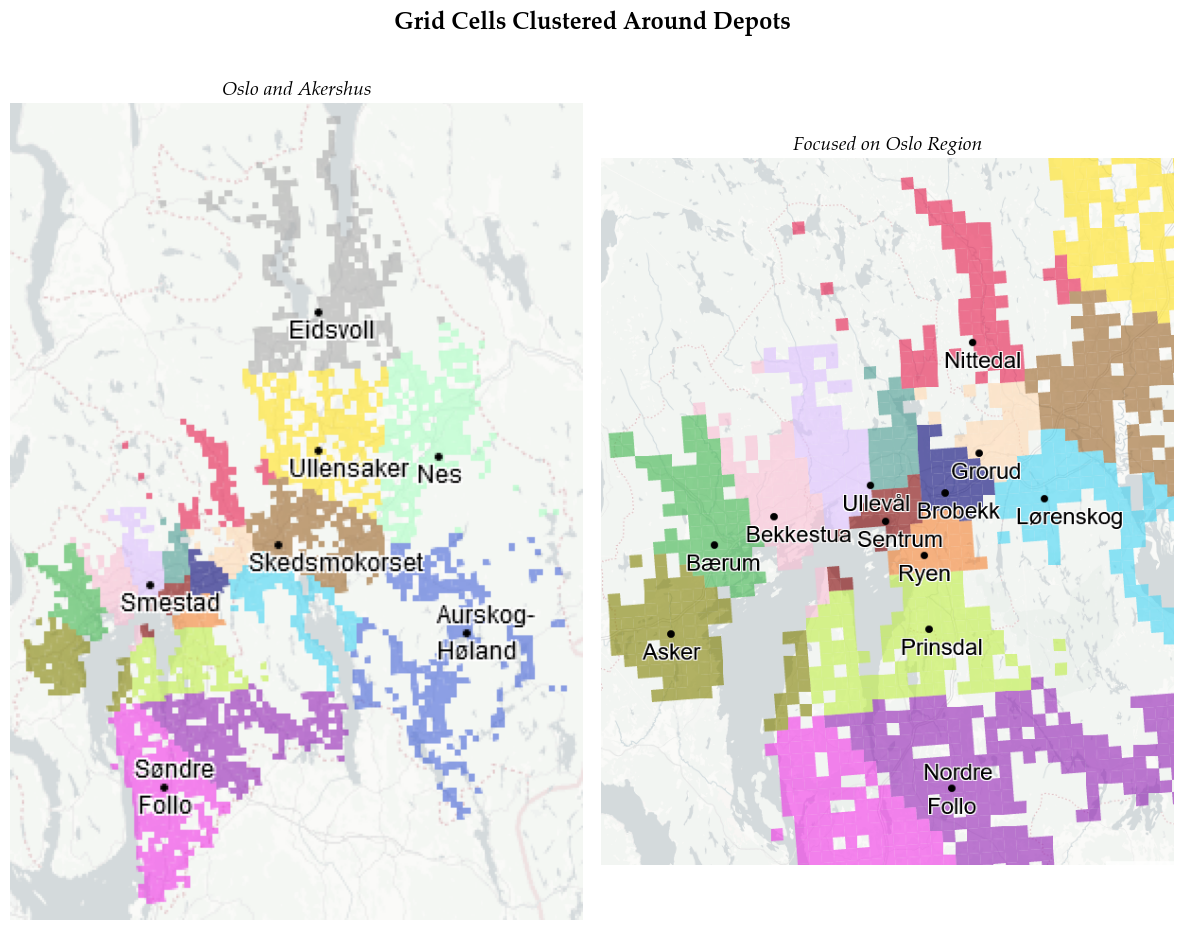

Eidsvoll: urban count 19.42%, total: 309
Ullensaker: urban count 16.38%, total: 232
Nes: urban count 10.76%, total: 251
Aurskog-Høland: urban count 8.22%, total: 292
Nittedal: urban count 15.07%, total: 73
Lørenskog: urban count 48.67%, total: 113
Asker: urban count 54.35%, total: 92
Bærum: urban count 64.94%, total: 77
Smestad: urban count 64.52%, total: 62
Ullevål: urban count 67.86%, total: 28
Brobekk: urban count 96.67%, total: 30
Sentrum: urban count 95.65%, total: 23
Prinsdal: urban count 42.61%, total: 115
Nordre Follo: urban count 16.82%, total: 220
Søndre Follo: urban count 22.69%, total: 260
Bekkestua: urban count 74.60%, total: 63
Grorud: urban count 85.29%, total: 34
Skedsmokorset: urban count 36.26%, total: 171
Ryen: urban count 86.21%, total: 29


In [16]:
plot_cluster(dataframe)


In [17]:
df = data_loader.data_preprocessor.load_enhanced_depots_dataframe()

df_subset = df.loc[0:18]

total_population = df_subset['total_incidents_cluster'].sum()

df.loc[0:18, "total_incidents_cluster_prob"] = (df_subset['total_incidents_cluster'] / total_population) * 100

print(df.loc[0:18, "total_incidents_cluster_prob"])


0      2.932397
1      3.321316
2      1.731321
3      1.262329
4      1.035398
5      7.749984
6      2.980735
7      4.789544
8      7.815296
9      7.822676
10     6.288767
11    19.668496
12     5.525319
13     3.981447
14     2.982211
15     4.377378
16     5.961101
17     3.960783
18     5.813503
Name: total_incidents_cluster_prob, dtype: float64


In [18]:
print(constants.PROJECT_DIRECTORY_PATH)

c:\Users\sindr\Documents\Emergency-Optimizers\Data-Processing


In [19]:
def load_csv(filename = "events", folder = "ex_6_least_NSGA2", ind = [0, 0, 0, 0, 0]):
    dataframes = []
    for seed in list(range(5)):
        dataframes.append(pd.read_csv(os.path.join(os.path.dirname(constants.PROJECT_DIRECTORY_PATH), "Simulator", "data", folder, filename + "_seed=" + str(seed) + "_ind_" + str(ind[seed]) + ".csv")))
    
    dataframe = pd.concat(dataframes, ignore_index=True)

    response_time_cols = [
        'duration_incident_creation',
        'duration_resource_appointment',
        'duration_resource_preparing_departure',
        'duration_dispatching_to_scene'
    ]
    dataframe['total_response_time'] = dataframe[response_time_cols].sum(axis=1)

    dataframe["complied"] = np.nan

    criteria = {
        ('A', True): 12 * 60,
        ('A', False): 25 * 60,
        ('H', True): 30 * 60,
        ('H', False): 40 * 60
    }

    for (triage, urban), group in dataframe.groupby(['triage_impression_during_call', 'urban']):
        if triage == 'V1':
            continue
    
        limit = criteria.get((triage, urban))
        if limit is not None:
            dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit

    return dataframe

dfs = [
    load_csv(filename="events_depot=-1", folder="ex_6_least_NSGA2", ind=[2, 2, 0, 2, 0]),
    load_csv(filename="events_depot=-1", folder="ex_6_avg_NSGA2", ind=[0, 0, 0, 0, 0]),
    load_csv(filename="events_depot=-1", folder="ex_6_most_NSGA2", ind=[12, 14, 0, 7, 0])
]

df = pd.concat(dfs, ignore_index=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3520 entries, 0 to 3519
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   time_call_received                     3520 non-null   object 
 1   triage_impression_during_call          3520 non-null   object 
 2   grid_id                                3520 non-null   int64  
 3   urban                                  3520 non-null   bool   
 4   allocation_index                       3520 non-null   int64  
 5   ambulance_id                           3520 non-null   int64  
 6   dispatched_from_depot_index            3520 non-null   int64  
 7   duration_incident_creation             3520 non-null   int64  
 8   duration_resource_appointment          3520 non-null   int64  
 9   duration_resource_preparing_departure  3520 non-null   int64  
 10  duration_dispatching_to_scene          3520 non-null   int64  
 11  dura

C:\Users\sindr\AppData\Local\Temp\ipykernel_14736\4052583874.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True False  True  True  True  True False  True  True  True
  True False  True  True  True  True False  True  True  True  True False
  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit
C:\Users\sindr\AppData\Local\Temp\ipykernel_14736\4052583874.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit
C:\Users\si

In [20]:
series = df["dispatched_from_depot_index"].value_counts(normalize=True, sort=True)

for depot, per in series.items():
    print(f"{data_loader.enhanced_depots_df.loc[depot, 'name']}: {per * 100:.2f}%")


Sentrum: 15.00%
Smestad: 8.84%
Ullevål: 8.75%
Grorud: 6.56%
Ryen: 6.45%
Lørenskog: 6.39%
Brobekk: 5.45%
Prinsdal: 5.06%
Bekkestua: 5.00%
Skedsmokorset: 4.77%
Søndre Follo: 4.60%
Bærum: 4.40%
Nordre Follo: 3.66%
Asker: 3.55%
Ullensaker: 3.21%
Eidsvoll: 2.70%
Nes: 2.10%
Aurskog-Høland: 1.76%
Nittedal: 1.73%
